# 03 Classification
Classify weather patterns using features extracted by ViT+SCL model. 

In [1]:
import torch

import numpy as np
import scipy.io as sio

import pandas as pd
import datetime as dt
import xarray as xr

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [2]:
root_dir = '/global/cfs/projectdirs/m1657/liuy351/TallTower/ContrastiveTransformer'


In [3]:
# feature_path = '../runs/transformer_embedding.s.e10b128.2001-2020.pt'
# time_idx_path = '../data/processed/preprocessed_data_time.2001-2020.csv'
# linkage_path = '../runs/linkage_metrix.s.e10b128.2001-2020.npy'
# clustering_label_path = '../clustering_linkage.s.e10b128.2001-2020.JJA.nc'

# feature_path = '../runs/transformer_embedding.s.e10b128.2001-2024.allmean.pt'
# time_idx_path = '../data/processed/preprocessed_data_time.2001-2024.allmean.csv'
# linkage_path = '../runs/linkage_metrix.s.e10b128.2001-2024.allmean.npy'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2001-2024.JJA.allmean.nc'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2001-2024.JJA.allmean.30dr12h.nc'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2001-2024.allmean.nc'
# clustering_label_path = '../runs/clustering_linkage.s.e10b128.2014-2024.allmean.nc'

model_option = 'allmean'
cluster_option = 'ANN.r30d24h' # r30d - remove 30 day running mean, 24h - 24 hour running mean
feature_path = f'../runs/transformer_embedding.s.e10b128.2001-2024.{model_option}.pt'
time_idx_path = f'../data/processed/preprocessed_data_time.2001-2024.{model_option}.csv'
linkage_path = f'../runs/linkage_metrix.s.e10b128.2014-2024.{model_option}.{cluster_option}.npy'
clustering_label_path = f'../runs/clustering_linkage.s.e10b128.2014-2024.{model_option}.{cluster_option}.nc'


In [4]:
# read features
feature = torch.load(feature_path, map_location=torch.device('cpu')).numpy()
feature.shape

(203776, 512)

In [5]:
time = pd.read_csv(time_idx_path, index_col=0).squeeze()
time = pd.to_datetime(time[:feature.shape[0]])
time.shape


(203776,)

In [6]:
feature = xr.DataArray(feature, dims=['time', 'feature'], coords=[time, np.arange(feature.shape[1])])
feature

<xarray.DataArray (time: 203776, feature: 512)> Size: 417MB
array([[-62.723087  ,  -8.511311  ,  27.111912  , ...,  38.63692   ,
         -8.505258  ,  19.79222   ],
       [-62.316776  ,  -8.256167  ,  27.340937  , ...,  38.94902   ,
         -8.425296  ,  18.967964  ],
       [-60.55759   ,  -8.198184  ,  26.027914  , ...,  38.724224  ,
        -10.300437  ,  18.785923  ],
       ...,
       [ -7.0820775 , -16.70791   ,   0.10557052, ...,   3.6874807 ,
        -14.028852  ,  -0.384283  ],
       [ -6.8142157 , -18.253843  ,   1.2852904 , ...,   4.539403  ,
        -15.816861  ,   0.75647885],
       [ -7.505142  , -19.611475  ,   1.7502732 , ...,   5.332559  ,
        -16.925676  ,  -0.8849916 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2MB 2001-01-01 ... 2024-03-31T15:00:00
  * feature  (feature) int64 4kB 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511

In [7]:
feature = feature - feature.rolling(time=24*30, min_periods=2, center=True).mean()
feature = feature.rolling(time=24, min_periods=2, center=True).mean()
# feature = feature.rolling(time=12, min_periods=2, center=True).mean()


In [8]:
feature['time.month'].isin([6,7,8])

<xarray.DataArray 'month' (time: 203776)> Size: 204kB
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2MB 2001-01-01 ... 2024-03-31T15:00:00

In [8]:
# xfeature = feature.sel(time=slice('2016-06-01', '2016-09-01'))

# xfeature = feature.sel(time=feature['time.month'].isin([6,7,8]))

xfeature = feature.sel(time=slice('2014-01-01', '2024-12-31'))

xfeature

<xarray.DataArray (time: 89824, feature: 512)> Size: 184MB
array([[  0.6354959 ,   0.77383935,  -5.195389  , ...,  -6.515157  ,
         -8.827377  ,  11.6074505 ],
       [  0.7227613 ,   0.5689595 ,  -4.93305   , ...,  -6.480345  ,
         -9.346789  ,  12.11156   ],
       [  0.6764519 ,   0.35919052,  -4.613723  , ...,  -6.2920203 ,
         -9.887258  ,  12.444057  ],
       ...,
       [ -4.2657423 ,   0.12513632,   6.2638955 , ...,  17.672047  ,
        -14.578285  , -13.599163  ],
       [ -4.063743  ,  -0.19076402,   6.126241  , ...,  17.144232  ,
        -14.281565  , -13.427783  ],
       [ -3.8146155 ,  -0.5445777 ,   6.098657  , ...,  16.655638  ,
        -13.951593  , -13.104756  ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 719kB 2014-01-01 ... 2024-03-31T15:00:00
  * feature  (feature) int64 4kB 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511

In [10]:
Z = linkage(xfeature, 'ward')
np.save(linkage_path, Z)

# Z = np.load(linkage_path)


In [11]:
Z[0,:]

array([4.15080000e+04, 4.15090000e+04, 1.27961381e+00, 2.00000000e+00])

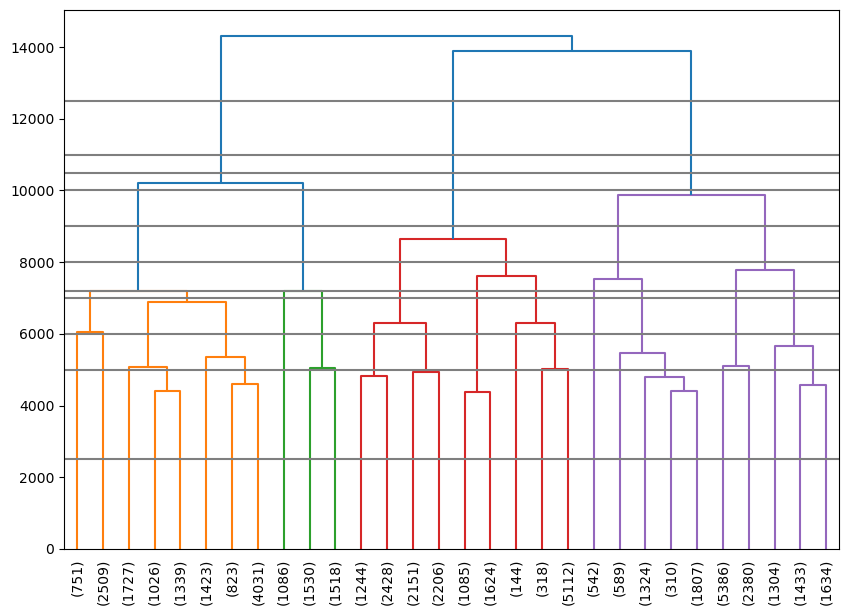

In [14]:
# thresholds = [500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 2000]
thresholds = [2500,5000,6000,7000,7200,8000,9000,10000,10500,11000,12500]
# thresholds = [15000,17500,20000,25000,28000,30000,35000]

fig, ax = plt.subplots(1,1, figsize=(10, 7))
labels = [f'Sample {i}' for i in range(xfeature.shape[0])]

_ = dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90, labels=labels, ax=ax)
# _ = dendrogram(Z, leaf_rotation=90, labels=labels, ax=ax)

for threshold in thresholds:
    ax.axhline(threshold, c='tab:gray')



In [15]:
output_labels = []
for threshold in thresholds:
    labels = fcluster(Z, t=threshold, criterion='distance')
    unique_labels = np.unique(labels)
    output_labels.append(labels)
    print(f"Number of clusters found: {len(unique_labels)} for {threshold}")
output_labels = np.stack(output_labels, axis=1)
output_labels = xr.DataArray(output_labels, dims=['time', 'threshold'], coords=[xfeature.time, thresholds], name='cluster')
output_labels.to_netcdf(clustering_label_path)

Number of clusters found: 97 for 2500
Number of clusters found: 22 for 5000
Number of clusters found: 15 for 6000
Number of clusters found: 11 for 7000
Number of clusters found: 10 for 7200
Number of clusters found: 6 for 8000
Number of clusters found: 5 for 9000
Number of clusters found: 4 for 10000
Number of clusters found: 3 for 10500
Number of clusters found: 3 for 11000
Number of clusters found: 3 for 12500


In [26]:
output_labels

<xarray.DataArray 'cluster' (time: 50784, threshold: 11)> Size: 2MB
array([[94, 19, 12, ...,  4,  3,  2],
       [94, 19, 12, ...,  4,  3,  2],
       [94, 19, 12, ...,  4,  3,  2],
       ...,
       [66, 14,  9, ...,  4,  3,  2],
       [66, 14,  9, ...,  4,  3,  2],
       [66, 14,  9, ...,  4,  3,  2]], dtype=int32)
Coordinates:
  * time       (time) datetime64[ns] 406kB 2001-06-01 ... 2023-08-31T23:00:00
  * threshold  (threshold) int64 88B 2500 5000 6000 7000 ... 10500 11000 12500

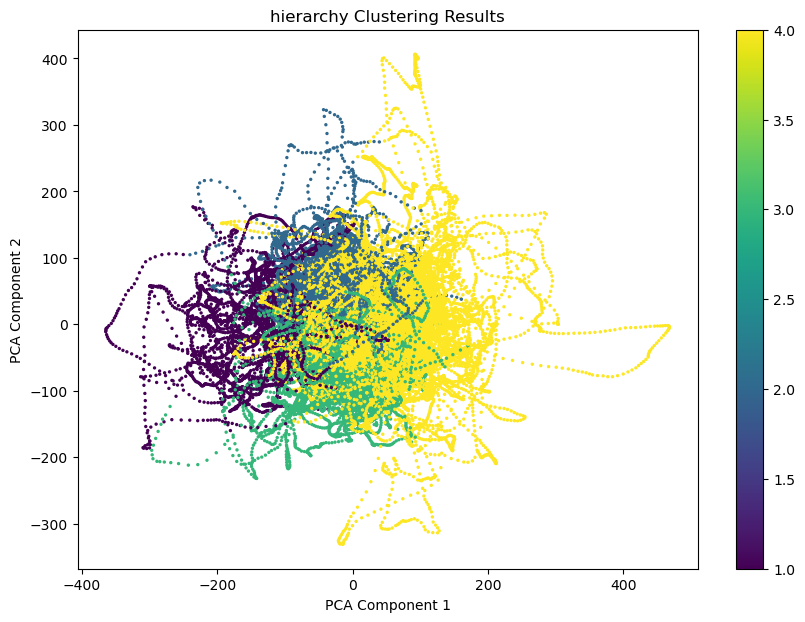

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(xfeature)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=output_labels.sel(threshold=10500), cmap='viridis', s=2)
plt.title("hierarchy Clustering Results")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

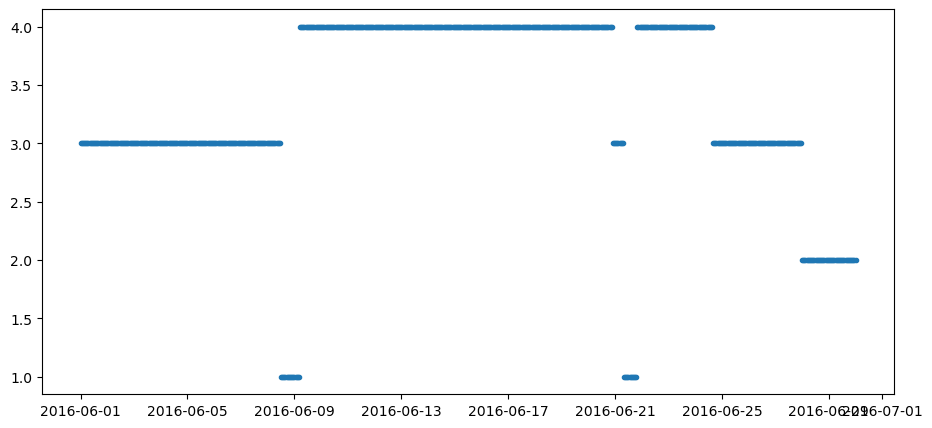

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(11,5))
_output_labels = output_labels.sel(time=slice('2016-06-01 00:00', '2016-06-30 00:00'))
ax.plot(_output_labels.time, _output_labels.sel(threshold=10500), ls='None', marker='.')


In [31]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
output_labels.sel(threshold=11000).sel(time=slice('2016-08-01 00:00', '2016-08-30 00:00')).to_pandas()


time
2016-08-01 00:00:00    3
2016-08-01 01:00:00    3
2016-08-01 02:00:00    3
2016-08-01 03:00:00    3
2016-08-01 04:00:00    3
2016-08-01 05:00:00    3
2016-08-01 06:00:00    3
2016-08-01 07:00:00    3
2016-08-01 08:00:00    3
2016-08-01 09:00:00    3
2016-08-01 10:00:00    3
2016-08-01 11:00:00    3
2016-08-01 12:00:00    2
2016-08-01 13:00:00    2
2016-08-01 14:00:00    2
2016-08-01 15:00:00    2
2016-08-01 16:00:00    2
2016-08-01 17:00:00    2
2016-08-01 18:00:00    2
2016-08-01 19:00:00    2
2016-08-01 20:00:00    2
2016-08-01 21:00:00    2
2016-08-01 22:00:00    2
2016-08-01 23:00:00    2
2016-08-02 00:00:00    2
2016-08-02 01:00:00    2
2016-08-02 02:00:00    2
2016-08-02 03:00:00    2
2016-08-02 04:00:00    2
2016-08-02 05:00:00    2
2016-08-02 06:00:00    2
2016-08-02 07:00:00    2
2016-08-02 08:00:00    2
2016-08-02 09:00:00    2
2016-08-02 10:00:00    2
2016-08-02 11:00:00    2
2016-08-02 12:00:00    2
2016-08-02 13:00:00    2
2016-08-02 14:00:00    2
2016-08-02 15:00:00 

In [ ]:
np.unique(labels.sel(time=slice('2016-06-01 00:00', '2016-06-30 00:00')))


AttributeError: 'numpy.ndarray' object has no attribute 'sel'

In [ ]:
kmean_results = xr.Dataset({key: (["time"], value) for key, value in kmean_results.items()})
kmean_results.coords['time'] = xfeature.time
kmean_results.attrs['description'] = 'Classification using K-means'
kmean_results.attrs['script'] = '/global/cfs/projectdirs/m1657/liuy351/TallTower/SCL/04.clustering_kmean.ipynb'
kmean_results.to_netcdf(f'{root_dir}/runs/cluster.kmeanss.e10b128.2001-2020.ERA5.nc')
kmean_results

<xarray.Dataset> Size: 703kB
Dimensions:  (time: 8784)
Coordinates:
  * time     (time) object 70kB '2016-01-01 00:00:00' ... '2016-12-31 23:00:00'
Data variables: (12/18)
    C2       (time) int32 35kB 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    C3       (time) int32 35kB 2 2 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    C4       (time) int32 35kB 3 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    C5       (time) int32 35kB 2 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2 2
    C6       (time) int32 35kB 0 0 0 0 0 3 3 0 0 0 3 3 ... 3 3 3 3 3 3 3 3 3 3 3
    C7       (time) int32 35kB 1 1 1 1 1 4 4 1 1 1 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    ...       ...
    C14      (time) int32 35kB 8 8 8 8 8 4 4 4 4 4 ... 4 4 13 13 13 13 13 13 13
    C15      (time) int32 35kB 14 14 14 14 14 3 3 3 3 ... 3 10 10 10 10 10 10 10
    C16      (time) int32 35kB 11 11 11 11 11 1 1 1 11 13 ... 1 1 1 5 5 5 5 1 5
    C17      (time) int32 35kB 5 5 5 5 5 16 16 16 16 ... 16 10 10 10 10 10 10 10
    C18      (time) int32 35kB 14 14 14 14 14 6 6 6 6 ... 6 17 17 17 17 17 17 17
    C19      (time) int32 35kB 12 12 12 12 12 2 2 2 2 5 ... 2 2 2 7 7 7 7 7 7 7
Attributes:
    description:  Classification using K-means
    script:       /global/cfs/projectdirs/m1657/liuy351/TallTower/SCL/04.clus...

In [ ]:
kmean_model.inertia_

53844480.0

In [ ]:
ss = xr.DataArray(list(ss.values()), coords=[list(ss.keys())], dims=["cat"])
ss

<xarray.DataArray (cat: 18)> Size: 72B
array([0.5007049 , 0.4727762 , 0.38045964, 0.34022245, 0.35067028,
       0.32726085, 0.32232925, 0.32947132, 0.32801116, 0.30074924,
       0.30702403, 0.30585438, 0.30565712, 0.29133463, 0.29509917,
       0.29593277, 0.26764473, 0.27014247], dtype=float32)
Coordinates:
  * cat      (cat) <U3 216B 'C2' 'C3' 'C4' 'C5' 'C6' ... 'C16' 'C17' 'C18' 'C19'

In [ ]:
wcss = xr.DataArray(list(wcss.values()), coords=[list(wcss.keys())], dims=["cat"])
wcss

<xarray.DataArray (cat: 18)> Size: 144B
array([2.97090144e+08, 2.22324480e+08, 1.68702224e+08, 1.43234256e+08,
       1.19858328e+08, 1.07952952e+08, 9.91233600e+07, 9.12735440e+07,
       8.42490240e+07, 7.83148800e+07, 7.36617440e+07, 6.91685520e+07,
       6.57368240e+07, 6.28690640e+07, 5.99334040e+07, 5.77926440e+07,
       5.58076120e+07, 5.38444800e+07])
Coordinates:
  * cat      (cat) <U3 216B 'C2' 'C3' 'C4' 'C5' 'C6' ... 'C16' 'C17' 'C18' 'C19'

In [ ]:
# Calculate the differences and second derivatives of the WCSS
diff_wcss = np.diff(wcss[2:])
diff2_wcss = np.diff(diff_wcss[2:])

# Find the elbow point
elbow_point = np.argmax(diff2_wcss) + 2 
elbow_point

2

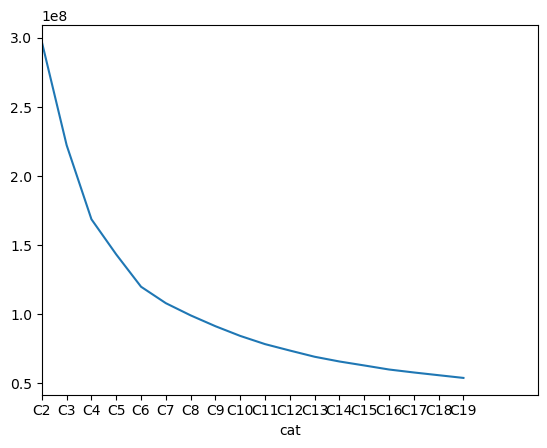

In [ ]:
wcss.plot(xlim=(0,20))